# Eigenfaces (Cnt'd from Tutorial 9)

To create the Eigen space, we use 144 cropped images from the Extended Yale B dataset.

These contain images from 6 different subjects, in 8 different poses and under 3 different illumination conditions (24 training images per subject).

All images are manually cropped to contain only the face area.

All images have the same size (192×168 pixels) and are stored with a .pgm extension.

Another subset of the Extended Yale B dataset is used to form a test set. The test set contains 13 images of each of the same subjects, 5 of them on pose similar to the ones from training and under new illuminations, 3 of them on a new pose and under illuminations from training, and 5 of image acquired with new poses and under new illuminations

In the Extended Yale B dataset, image files are named so that the subject ID, the pose code and the illumination code could be extracted from the file names. For example, “yaleB11_P01A+000E-20.pgm” denotes an image of the subject “11”, in pose “01”, and under “-20” illumination condition.

### Let's create a class to aid us in loading the training and testing data and parsing the filenames

In [29]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

class YaleDatasetLoader:
    # the __init__ function is automatically called upon instantiation
    # is't a good practice to initialize/reset all class members here
    def __init__(self,trainingBaseAddress,trainingfilelist):
        # To open a file for reading/writing in Python
        file_object  = open(trainingfilelist, 'r') 
        
        # Read all the lines in the text file into a list of strings
        imageNames = file_object.readlines()
        
        # Total number of images
        self.N = len(imageNames)
        
        # Close the file
        file_object.close() 
        
        # data placeholder
        self.data = []
        
        # Go through the imageNames 
        for i in range(self.N):
            # get rid of \n, read by file_object.readlines()
            last = imageNames[i].find('pgm')
            imgAddress = trainingBaseAddress + '/' + imageNames[i][:last+3]
            
            # extract the subject ID
            first = imageNames[i].find('B')
            second = imageNames[i].find('_')
            subjectID = int( imageNames[i][first+1:second] )
            
            # extract the pose code
            first = imageNames[i].find('P')
            second = imageNames[i].find('A')
            poseCode = int( imageNames[i][first+1:second] )            
            
            # extract the illumination code
            first = imageNames[i].find('E')
            second = imageNames[i].find('.')
            illumCode = int( imageNames[i][first+1:second] )            
            
            # load the image
            img = cv2.imread(imgAddress, cv2.IMREAD_GRAYSCALE)
            
            # store the image info into the dataset
            self.data.append({"img":img,"subjectID":subjectID,"poseCode":poseCode,"illumCode":illumCode}) 
            
    def demo(self):   
        # Display all images of the first image
        print("All images of the first subject")
        # get the id of the first data
        ID = self.data[0]["subjectID"]
        pltID = 0
        for i in range(self.N):
            if self.data[i]["subjectID"] == ID:
                pltID = pltID + 1
                plt.subplot(3,8,pltID),plt.imshow(self.data[i]["img"], cmap='gray')
                plt.xticks([]), plt.yticks([])
        plt.show()
        
        # Display an image from each subject
        print("Images of all the subjects")
        # get the pose/illum code of the first image
        poseCode = self.data[6]["poseCode"]
        illumCode = self.data[6]["illumCode"]
        pltID = 0
        for i in range(self.N):
            if self.data[i]["poseCode"] == poseCode and self.data[i]["illumCode"] == illumCode:
                pltID = pltID + 1
                plt.subplot(1,6,pltID),plt.imshow(self.data[i]["img"], cmap='gray')
                plt.xticks([]), plt.yticks([])
        plt.show()                        

Training set
All images of the first subject


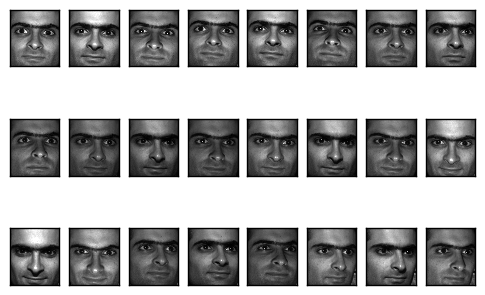

Images of all the subjects


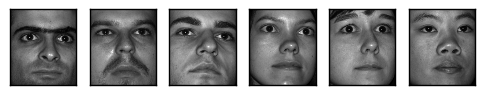

Test set
All images of the first subject


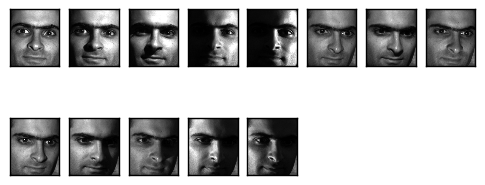

Images of all the subjects


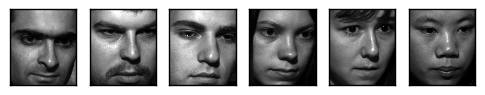

In [31]:
# Create a YaleDatasetLoader object for the training set
Dataset = YaleDatasetLoader('./Training Images','Training Images.txt')
# run the demo
print("Training set")
Dataset.demo()

# Create another YaleDatasetLoader object for the test set
TestSet = YaleDatasetLoader('./Test Images','Test Images.txt')
# run the demo
print("Test set")
TestSet.demo()

### Calc eigenfaces and the mean face

Create an 𝑁×𝐷 feature matrix 𝐴

    𝑁 denotes the number of training images

    𝐷 denotes the size of each feature vector (each feature vector is constructed by converting the training images into 1×𝐷 vectors)

In [5]:
# Read the size of the images
height,width = Dataset.data[0]["img"].shape
# feature size
D = height * width
# initialize and fill the feature matrix
A = np.empty((Dataset.N, D), dtype=np.float64)
for i in range(Dataset.N):
    A[i,:] = np.float64(Dataset.data[i]["img"]).reshape((1,-1))

Compute the 1×𝐷 mean face, as the average of all training faces

In [6]:
# Compute the mean face
meanFace = np.mean(A, axis=0)

Subtract the mean face from each feature vector and update the feature matrix 𝐴

In [7]:
# Subtract the mean face from each feature vector
A = A - meanFace  

Calculate the 𝑁×𝑁 covariance matrix 𝐶′=𝐴∗𝐴^𝑇 (𝐴^𝑇 is A transposed)

In [8]:
# Calc the covariance matrix
C = A.dot(A.transpose())

Find all the 1×𝑁 eigen vectors 𝑣′ and the eigen values of the covariance matrix 𝐶′

Compute each 1×𝐷 Eigenface 𝑣=𝑣′∗𝐴

Normalize the L2 norm of each Eigenface 𝑣

In [9]:
# Find the eigenvectors/eigenvalues of C
retval, eigenvalues, eigenvectors = cv2.eigen(C)

# Compute each 1×𝐷 Eigenface 𝑣
v = eigenvectors.dot(A)

# Normalize the L2 norm of each Eigenface 𝑣
for i in range(v.shape[0]):
    v[i,:] = cv2.normalize(v[i,:],0,1,cv2.NORM_L2).flatten()

### Display the meanface and the first 24 eigenfaces

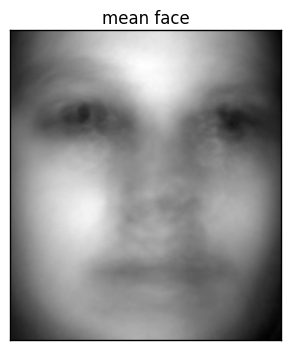

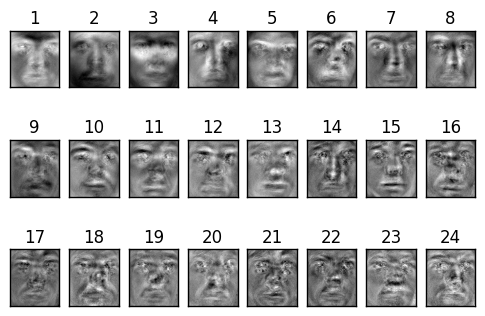

In [10]:
# Reshape the mean face to a 2D matrix and display
plt.imshow(meanFace.reshape((height,width)), cmap='gray'),plt.title("mean face")
plt.xticks([]), plt.yticks([])
plt.show()

# Reshape each eigenface to a 2D matrix and display
for i in range(24):
    plt.subplot(3,8,i+1),plt.imshow(v[i,:].reshape((height,width)), cmap='gray'), plt.title(str(i+1))
    plt.xticks([]), plt.yticks([])
plt.show()

### Compute the reconstruction error

One way to evaluate the performance of Eigenfaces is to project a face image onto the Eigen space and then reconstruct the face image by projecting back from the Eigen space. Note that this procedure is usually done using a subset of Eigenfaces (the best K eigenfaces) instead of using all of them.

Given K, do for all training images:

    1. Reshape the image into a 1×𝐷 vector

    2. Project the image to the Eigen space using the best K eigenfaces

    3. Reconstruct the image by projecting back to the pixel space

    4. Calculate the mean square error between the image and its reconstructed version

5.Calculate the mean error over all the training images

To project a 1×𝐷 input image into the 𝐾-dimensional Eigen space:   output = (input - meanFace) * eigenFaces^𝑇

To project a 1×𝐾 input image in the eigenspace back to the 𝐷-dimensional pixel space:  output = input * eigenFaces + meanFace

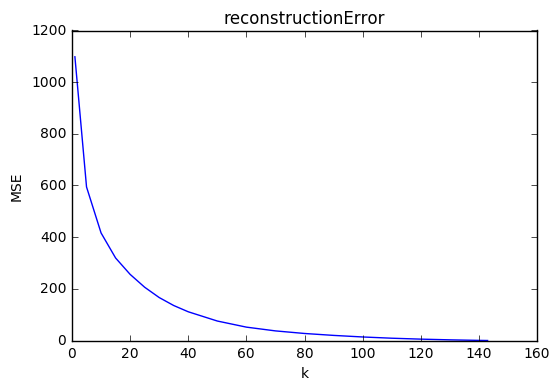

In [38]:
K = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 143])

# Loop over different values for K
reconstructionError = np.zeros(K.shape[0])
for k in range(K.shape[0]):
    # Use a subset of eigenfaces
    eigenFaces = v[0:K[k],:]
    # loop over all training images
    MSE = np.zeros(Dataset.N)
    for i in range(Dataset.N):       
        # Reshape the image into a 1×𝐷 vector
        img = np.float64(Dataset.data[i]["img"]).reshape((1,-1))
        # Project the image to the Eigen space
        projection = (img - meanFace).dot(eigenFaces.transpose()) 
        # Reconstruct the image by projecting back to the pixel space
        recontructed = projection.dot(eigenFaces) + meanFace
        # Calc the MSE
        MSE[i] = np.mean((img - recontructed)*(img - recontructed))
    reconstructionError[k] = np.mean(MSE)
    
# Plot the result
plt.plot(K,reconstructionError)
plt.title('reconstructionError'),plt.xlabel('k'),plt.ylabel('MSE')
plt.show()

Let's compute the reconstruction error for the test set

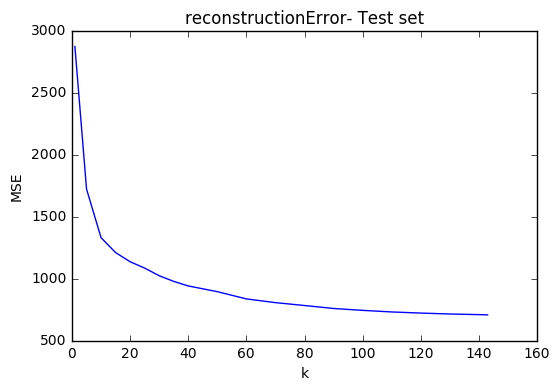

In [39]:
K = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 143])

# Loop over different values for K
reconstructionError = np.zeros(K.shape[0])
for k in range(K.shape[0]):
    # Use a subset of eigenfaces
    eigenFaces = v[0:K[k],:]
    # loop over all training images
    MSE = np.zeros(TestSet.N)
    for i in range(TestSet.N):       
        # Reshape the image into a 1×𝐷 vector
        img = np.float64(TestSet.data[i]["img"]).reshape((1,-1))
        # Project the image to the Eigen space
        projection = (img - meanFace).dot(eigenFaces.transpose()) 
        # Reconstruct the image by projecting back to the pixel space
        recontructed = projection.dot(eigenFaces) + meanFace
        # Calc the MSE
        MSE[i] = np.mean((img - recontructed)*(img - recontructed))
    reconstructionError[k] = np.mean(MSE)
    
# Plot the result
plt.plot(K,reconstructionError)
plt.title('reconstructionError- Test set'),plt.xlabel('k'),plt.ylabel('MSE')
plt.show()

Let's compute the reconstruction error for a non-face image

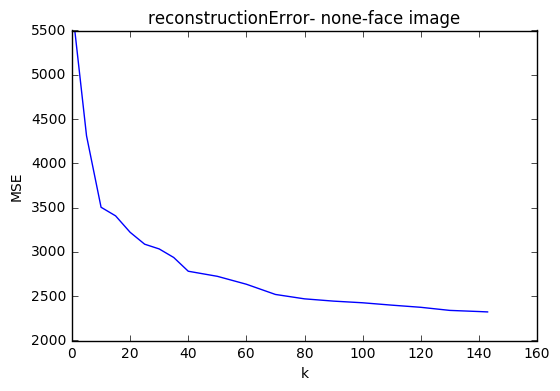

In [45]:
K = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 143])

# Load the image
img = cv2.imread("non_face.jpg",cv2.IMREAD_GRAYSCALE)
# Reshape the image into a 1×𝐷 vector
img = np.float64(img).reshape((1,-1))

# Loop over different values for K
reconstructionError = np.zeros(K.shape[0])
for k in range(K.shape[0]):
    # Use a subset of eigenfaces
    eigenFaces = v[0:K[k],:]      
    # Project the image to the Eigen space
    projection = (img - meanFace).dot(eigenFaces.transpose()) 
    # Reconstruct the image by projecting back to the pixel space
    recontructed = projection.dot(eigenFaces) + meanFace
    # Calc the error    
    reconstructionError[k] = np.mean((img - recontructed)*(img - recontructed))
    
# Plot the result
plt.plot(K,reconstructionError)
plt.title('reconstructionError- none-face image'),plt.xlabel('k'),plt.ylabel('MSE')
plt.show()

### Visualizing reconstruction

Let's pick a random image from the training dataset, project it to the eigenspace and reconstruct it using various number of eigenfaces

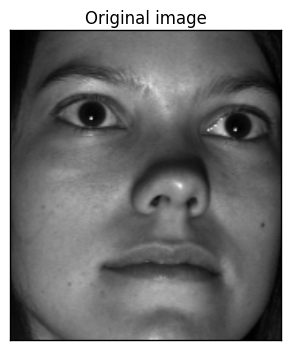

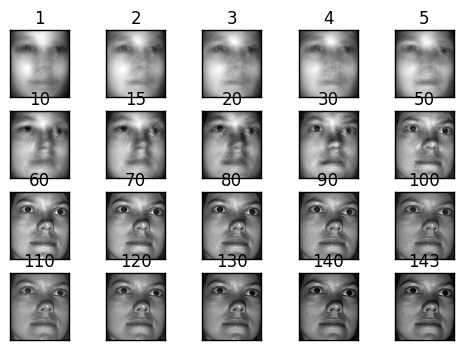

In [21]:
K = np.array([1,2,3,4,5,10,15,20,30,50,60,70,80,90,100,110,120,130,140,143])

# Pick a random image
idx = np.random.randint(0,Dataset.N)

# Display
plt.imshow(Dataset.data[idx]["img"], cmap='gray'),plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.show()

for k in range(K.shape[0]):
    # Use a subset of eigenfaces
    eigenFaces = v[0:K[k],:]    
    
    # Reshape the image into a 1×𝐷 vector
    img = np.float64(Dataset.data[idx]["img"]).reshape((1,-1))
    # Project the image to the Eigen space
    projection = (img - meanFace).dot(eigenFaces.transpose()) 
    # Reconstruct the image by projecting back to the pixel space
    recontructed = projection.dot(eigenFaces) + meanFace
    
    # Display
    plt.subplot(4,5,k+1),plt.imshow(recontructed.reshape((height,width)), cmap='gray'), plt.title(str(K[k]))
    plt.xticks([]), plt.yticks([])
plt.show()

Let's pick a random image from the test set, project it to the eigenspace and reconstruct it using various number of eigenfaces

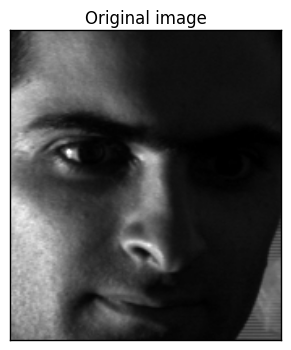

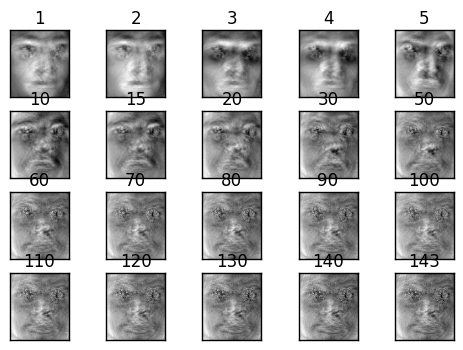

In [40]:
K = np.array([1,2,3,4,5,10,15,20,30,50,60,70,80,90,100,110,120,130,140,143])

# Pick a random image
idx = np.random.randint(0,TestSet.N)

# Display
plt.imshow(TestSet.data[idx]["img"], cmap='gray'),plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.show()

for k in range(K.shape[0]):
    # Use a subset of eigenfaces
    eigenFaces = v[0:K[k],:]    
    
    # Reshape the image into a 1×𝐷 vector
    img = np.float64(TestSet.data[idx]["img"]).reshape((1,-1))
    # Project the image to the Eigen space
    projection = (img - meanFace).dot(eigenFaces.transpose()) 
    # Reconstruct the image by projecting back to the pixel space
    recontructed = projection.dot(eigenFaces) + meanFace
    
    # Display
    plt.subplot(4,5,k+1),plt.imshow(recontructed.reshape((height,width)), cmap='gray'), plt.title(str(K[k]))
    plt.xticks([]), plt.yticks([])
plt.show()

Let's pick a random image from the internet, project it to the eigenspace and reconstruct it using various number of eigenfaces

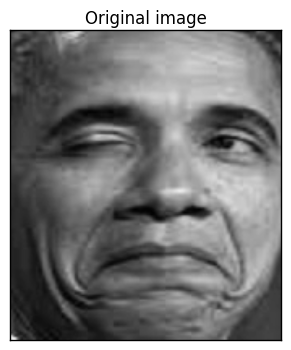

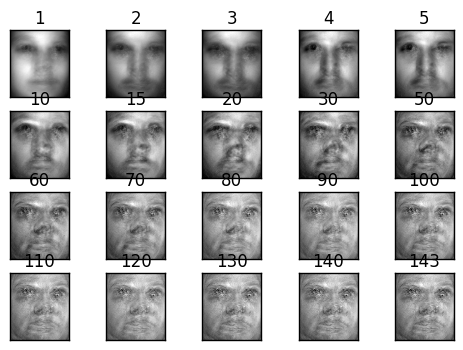

In [41]:
K = np.array([1,2,3,4,5,10,15,20,30,50,60,70,80,90,100,110,120,130,140,143])

# Load the image
img = cv2.imread("test_face.jpg",cv2.IMREAD_GRAYSCALE)

# Display
plt.imshow(img, cmap='gray'),plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.show()

for k in range(K.shape[0]):
    # Use a subset of eigenfaces
    eigenFaces = v[0:K[k],:]    
    
    # Reshape the image into a 1×𝐷 vector
    img = np.float64(img.reshape((1,-1)))
    # Project the image to the Eigen space
    projection = (img - meanFace).dot(eigenFaces.transpose()) 
    # Reconstruct the image by projecting back to the pixel space
    recontructed = projection.dot(eigenFaces) + meanFace
    
    # Display
    plt.subplot(4,5,k+1),plt.imshow(recontructed.reshape((height,width)), cmap='gray'), plt.title(str(K[k]))
    plt.xticks([]), plt.yticks([])
plt.show()

Let's pick a non-face image from the internet, project it to the eigenspace and reconstruct it using various number of eigenfaces

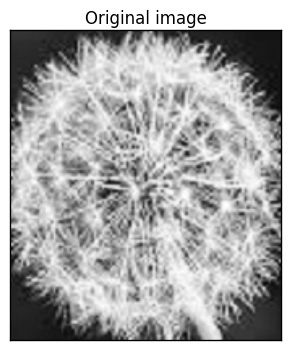

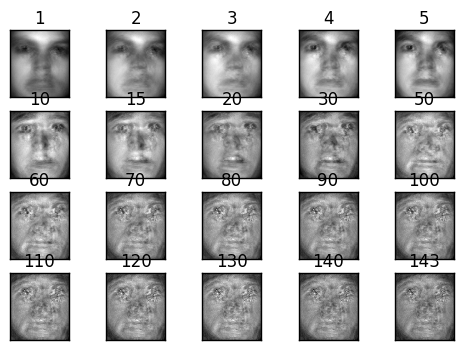

In [43]:
K = np.array([1,2,3,4,5,10,15,20,30,50,60,70,80,90,100,110,120,130,140,143])

# Load the image
img = cv2.imread("non_face.jpg",cv2.IMREAD_GRAYSCALE)

# Display
plt.imshow(img, cmap='gray'),plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.show()

for k in range(K.shape[0]):
    # Use a subset of eigenfaces
    eigenFaces = v[0:K[k],:]    
    
    # Reshape the image into a 1×𝐷 vector
    img = np.float64(img.reshape((1,-1)))
    # Project the image to the Eigen space
    projection = (img - meanFace).dot(eigenFaces.transpose()) 
    # Reconstruct the image by projecting back to the pixel space
    recontructed = projection.dot(eigenFaces) + meanFace
    
    # Display
    plt.subplot(4,5,k+1),plt.imshow(recontructed.reshape((height,width)), cmap='gray'), plt.title(str(K[k]))
    plt.xticks([]), plt.yticks([])
plt.show()

## Face recognition using Eigenfaces

The recognition procedure is as follows: We should first project all the training images onto the Eigen space. Then, to recognize a new test image, we should project it to the Eigen space (using K eigenfaces) and then find its nearest neighbor in the 𝐾 dimensional Eigen space. We can then set the subject label of the test image as the subject label of the nearest training image.

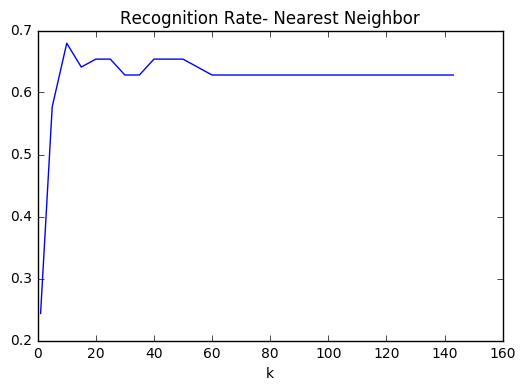

In [135]:
K = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 143])

# Loop over different values for K
recognitionError = np.zeros(K.shape[0])
for k in range(K.shape[0]):
    eigenFaces = v[0:K[k],:]

    # Compute the projection of all the training images
    projections = []
    for i in range(Dataset.N):       
        # Reshape the image into a 1×𝐷 vector
        img = np.float64(Dataset.data[i]["img"]).reshape((1,-1))
        # Project the image to the Eigen space
        projection = (img - meanFace).dot(eigenFaces.transpose()) 
        # store into memory
        projections.append({"projection":projection,"subjectID":Dataset.data[i]["subjectID"]}) 

    
    # Recognizing test images   
    for i in range(TestSet.N):       
        # Reshape the image into a 1×𝐷 vector
        img = np.float64(TestSet.data[i]["img"]).reshape((1,-1))
        # Project the image to the Eigen space
        test_projection = (img - meanFace).dot(eigenFaces.transpose()) 
        # Find the Nearest Neighbor in Eigenspace
        min_distance = float('Inf')
        matchIdx = -1
        for j in range(Dataset.N):
            # Compute the Euclidean distance between the projected images        
            dist = np.linalg.norm( test_projection - projections[j]["projection"] )
            if dist < min_distance:
                min_distance = dist
                matchIdx = j
            
        # label the test image using the best match ID
        bestMatchId = projections[matchIdx]["subjectID"]
    
        # Compare the assigned label of the test image with its true subject label
        # If they do no match, count this as an error
        if bestMatchId != TestSet.data[i]["subjectID"]:
            recognitionError[k] = recognitionError[k] + 1

# Calculate the recognition rate of the method as 1.0 - ratio of the errors to the total number of testing images
recognitionRate = 1 - recognitionError / TestSet.N

# Plot the result
plt.plot(K,recognitionRate)
plt.title('Recognition Rate- Nearest Neighbor'),plt.xlabel('k')
plt.show()    

Let's train an SVM classifier instead of the Nearest Neighbor classifier

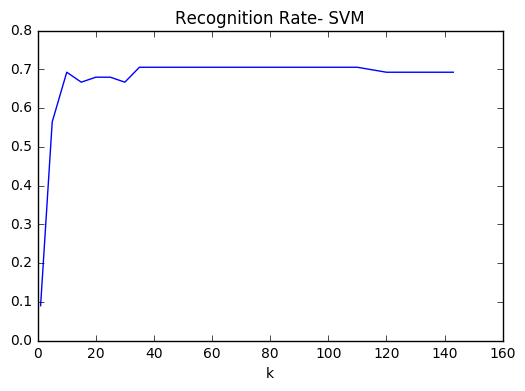

In [152]:
K = np.array([1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 143])

# Loop over different values for K
recognitionError = np.zeros(K.shape[0])
for k in range(K.shape[0]):
    eigenFaces = v[0:K[k],:]

    # Compute the projection of all the training images
    train_data = np.ndarray( (Dataset.N,K[k]), dtype = np.float32)
    label_data = np.ndarray(  Dataset.N, dtype = np.int32)
    for i in range(Dataset.N):       
        # Reshape the image into a 1×𝐷 vector
        img = np.float64(Dataset.data[i]["img"]).reshape((1,-1))
        # Project the image to the Eigen space
        projection = (img - meanFace).dot(eigenFaces.transpose()) 
        # add to the feature matrix
        train_data[i,:] = np.float32(projection)
        label_data[i] = np.int32(Dataset.data[i]["subjectID"])

    # Create an OpenCV SVM object
    svm = cv2.ml.SVM_create()
    # Type of a SVM formulation. Possible values are:
    # SVM_C_SVC: C-Support Vector Classification. n-class classification with penalty multiplier C for outliers
    svm.setType(cv2.ml.SVM_C_SVC)
    # Type of a SVM kernel. Possible values are: SVM_LINEAR, SVM_POLY, SVM_RBF and SVM_SIGMOID 
    svm.setKernel(cv2.ml.SVM_LINEAR )
    # Parameter C of a SVM optimization problem
    #svm.setC(2.3)
    
    # Stop criteria (iteration/tolerance)
    svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 100, 1.e-06))
    
    # Training
    svm.train(train_data, cv2.ml.ROW_SAMPLE, label_data)

    # Recognizing test images   
    for i in range(TestSet.N):       
        # Reshape the image into a 1×𝐷 vector
        img = np.float64(TestSet.data[i]["img"]).reshape((1,-1))
        # Project the image to the Eigen space
        test_projection = (img - meanFace).dot(eigenFaces.transpose()) 
        # Predict the subject ID using SVM
        bestMatchId = svm.predict( np.float32(test_projection) )
        bestMatchId = bestMatchId[1]
    
        # Compare the assigned label of the test image with its true subject label
        # If they do no match, count this as an error
        if bestMatchId != TestSet.data[i]["subjectID"]:
            recognitionError[k] = recognitionError[k] + 1

# Calculate the recognition rate of the method as 1.0 - ratio of the errors to the total number of testing images
recognitionRate = 1.0 - recognitionError / TestSet.N

# Plot the result
plt.plot(K,recognitionRate)
plt.title('Recognition Rate- SVM'),plt.xlabel('k')
plt.show()